In [1]:
# Importations nécessaires
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:

import findspark
findspark.init()

In [3]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 4g pyspark-shell"

In [4]:
#Creer une session spark et tester avec un mesage hello spark
spark=SparkSession.builder.appName("Regression").getOrCreate()
df=spark.sql("select 'spark' as hello")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [5]:
print("📂 Chargement des données King County...")
df = spark.read.csv("kc_house_data.csv", header=True, inferSchema=True)

📂 Chargement des données King County...


In [6]:
# Aperçu des données
print("📊 Aperçu des données :")
print(f"Nombre d'observations : {df.count():,}")
print(f"Nombre de variables : {len(df.columns)}")
print("\n" + "="*60)

📊 Aperçu des données :
Nombre d'observations : 21,613
Nombre de variables : 21



In [7]:
# Affichage des premières lignes
print("🔍 Premières observations :")
df.show(5)

🔍 Premières observations :
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7| 

In [8]:
# Informations sur les colonnes
print("\n📋 Structure des données :")
print("Colonnes disponibles :")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


📋 Structure des données :
Colonnes disponibles :
 1. id
 2. date
 3. price
 4. bedrooms
 5. bathrooms
 6. sqft_living
 7. sqft_lot
 8. floors
 9. waterfront
10. view
11. condition
12. grade
13. sqft_above
14. sqft_basement
15. yr_built
16. yr_renovated
17. zipcode
18. lat
19. long
20. sqft_living15
21. sqft_lot15


In [9]:
# Informations sur les types
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [10]:
print("\n📈 Statistiques descriptives:")
df.describe().show()


📈 Statistiques descriptives:
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|           date|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+--------

#2. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

In [11]:
# Vérification des valeurs manquantes
print("🔍 Valeurs manquantes par colonne:")
import pyspark.sql.functions as F  # Alias standard

df.select([F.count(F.when(F.col(column_name).isNull(), F.lit(1))).alias(column_name) for column_name in df.columns]).show()

🔍 Valeurs manquantes par colonne:
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
| id|date|price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat|long|sqft_living15|sqft_lot15|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
|  0|   0|    0|       0|        0|          0|       0|     0|         0|   0|        0|    0|         0|            0|       0|           0|      0|  0|   0|            0|         0|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+



In [12]:
# Vérification des doublons
duplicates = df.count() - df.dropDuplicates().count()
print(f"\n🔄 Nombre de doublons : {duplicates}")
if duplicates > 0:
    df = df.dropDuplicates()
    print(f"✅ {duplicates} doublons supprimés")


🔄 Nombre de doublons : 0


In [13]:
# Conversion pour visualisations
df_pandas = df.toPandas()

#3. ANALYSE DE CORRÉLATION APPROFONDIE

In [14]:
# Matrice de corrélation complète
df_pandas = df.toPandas()  # Conversion en pandas
df_numeric = df_pandas.select_dtypes(include=['int64', 'float64'])
correlation_matrix = df_numeric.corr()

In [15]:
# Variables numériques pour l'analyse
numeric_cols = ['price', 'sqft_living15', 'view', 'lat', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'grade', 'sqft_above', 'sqft_basement', 'waterfront', 'yr_renovated', 'sqft_lot15', 'condition', 'id', 'long', 'zipcode', 'yr_built']
numeric_cols = [col for col in numeric_cols if col in df_pandas.columns]

In [16]:
# Corrélations avec le prix (triées par importance)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import builtins  # For built-in abs function

# Assemble features into a vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Calculate correlation matrix
matrix = Correlation.corr(df_vector, "features").head()
correlation_matrix = matrix[0].toArray()

# Create a mapping of column indices to names
col_mapping = {i: col_name for i, col_name in enumerate(numeric_cols)}

# Find price column index
price_index = numeric_cols.index('price')

# Extract correlations with price
print("\n🏠 Corrélations avec le prix:")
price_correlations = []
for i, corr_val in enumerate(correlation_matrix[price_index]):
    if i != price_index:  # Skip self-correlation
        price_correlations.append((col_mapping[i], float(corr_val)))

# Sort by correlation value (descending: strongest positive first, then strongest negative)
price_correlations.sort(key=lambda x: x[1], reverse=True)

# Display results
for var, corr_val in price_correlations:
    print(f"{var:15s}: {corr_val:.3f}")


🏠 Corrélations avec le prix:
sqft_living    : 0.702
grade          : 0.667
sqft_above     : 0.606
sqft_living15  : 0.585
bathrooms      : 0.525
view           : 0.397
sqft_basement  : 0.324
bedrooms       : 0.308
lat            : 0.307
waterfront     : 0.266
floors         : 0.257
yr_renovated   : 0.126
sqft_lot       : 0.090
sqft_lot15     : 0.082
yr_built       : 0.054
condition      : 0.036
long           : 0.022
id             : -0.017
zipcode        : -0.053


In [17]:
# Détection de multicolinéarité (corrélations élevées entre variables)
import builtins  # Pour la fonction abs de Python
print("\n⚠️  Multicolinéarité détectée (|r| > 0.8):")
high_corr_pairs = []

# Utiliser la matrice de corrélation numpy et les indices des colonnes
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        var1, var2 = numeric_cols[i], numeric_cols[j]
        # Utiliser les indices i et j pour accéder à la matrice numpy
        corr_val = float(correlation_matrix[i, j])  # Convertir en float Python
        if builtins.abs(corr_val) > 0.8:  # Utiliser builtins.abs
            high_corr_pairs.append((var1, var2, corr_val))
            print(f"{var1:15s} ↔ {var2:15s}: {corr_val:.3f}")

if not high_corr_pairs:
    print("    ✅ Aucune multicolinéarité critique détectée")


⚠️  Multicolinéarité détectée (|r| > 0.8):
sqft_living     ↔ sqft_above     : 0.877


In [18]:
# Visualisations complètes
plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

Text(0, 0.5, 'Fréquence')

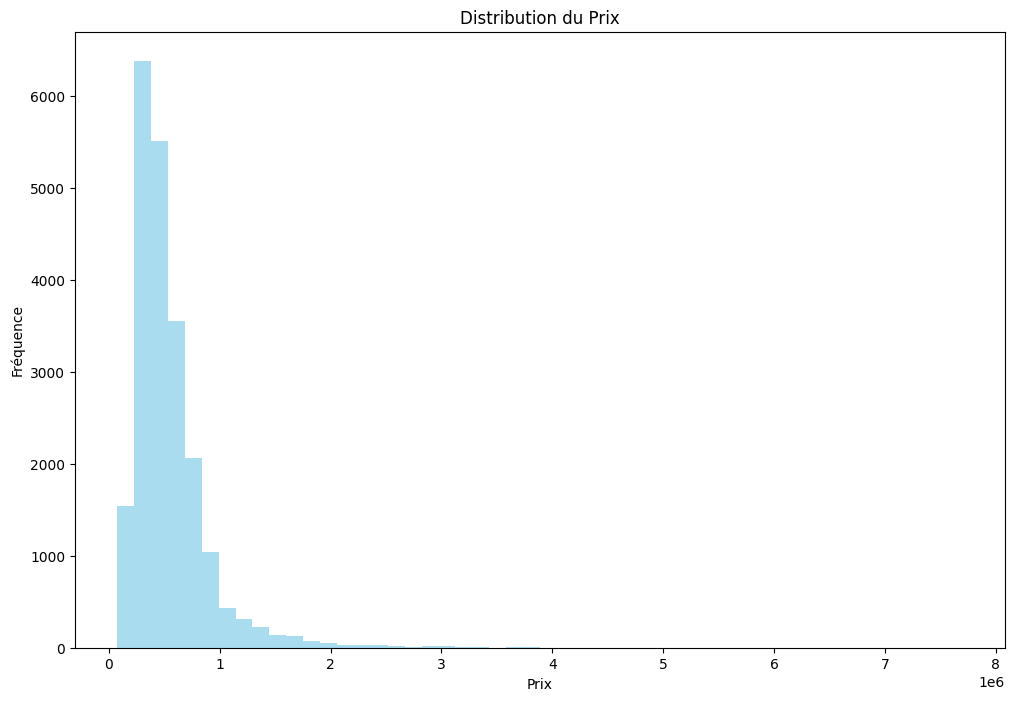

In [82]:
# 1. Distribution du prix


# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.hist(df_pandas['price'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution du Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'id'),
  Text(0, 1.5, 'price'),
  Text(0, 2.5, 'bedrooms'),
  Text(0, 3.5, 'bathrooms'),
  Text(0, 4.5, 'sqft_living'),
  Text(0, 5.5, 'sqft_lot'),
  Text(0, 6.5, 'floors'),
  Text(0, 7.5, 'waterfront'),
  Text(0, 8.5, 'view'),
  Text(0, 9.5, 'condition'),
  Text(0, 10.5, 'grade'),
  Text(0, 11.5, 'sqft_above'),
  Text(0, 12.5, 'sqft_basement'),
  Text(0, 13.5, 'yr_built'),
  Text(0, 14.5, 'yr_renovated'),
  Text(0, 15.5, 'zipcode'),
  Text(0, 16.5, 'lat'),
  Text(0, 17.5, 'long'),
  Text(0, 18.5, 'sqft_living15'),
  Text(0, 19.5, 'sqft_lot15')])

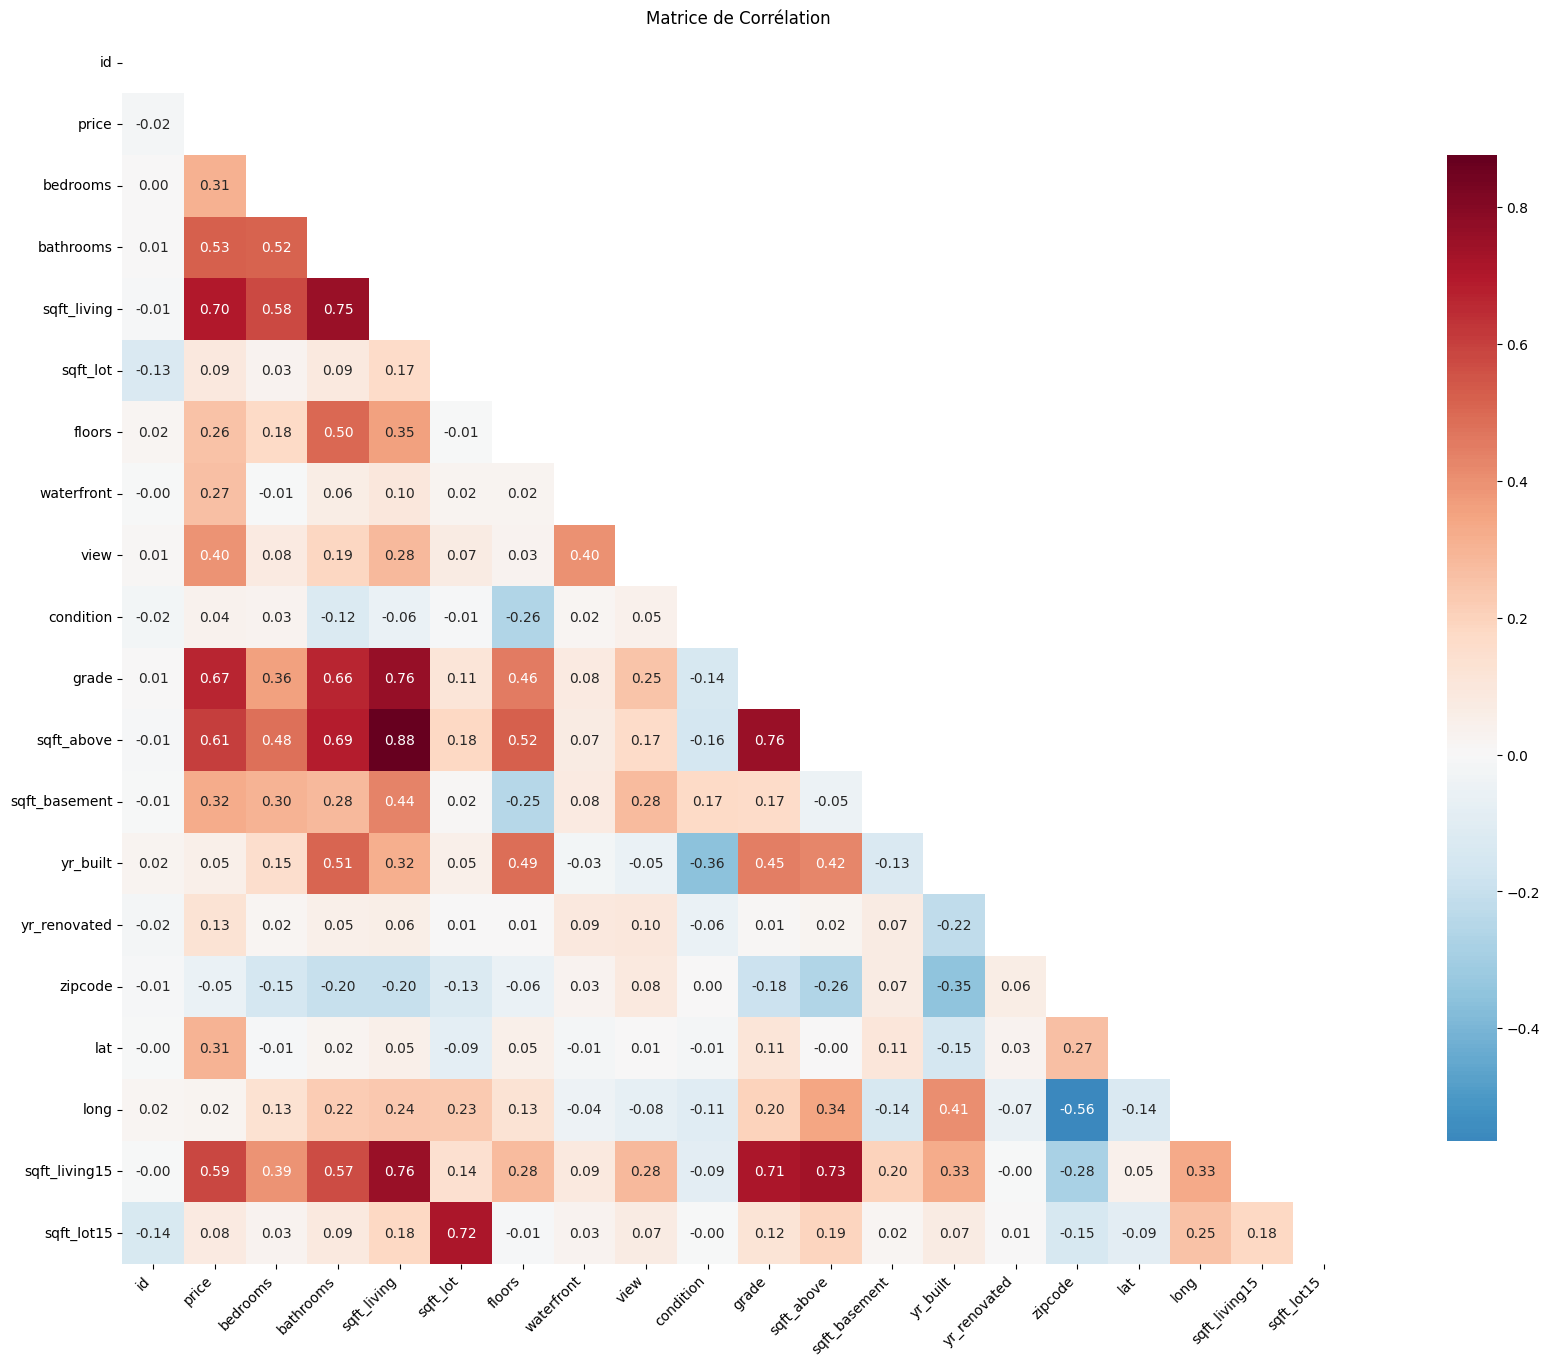

In [83]:
# 2. Matrice de corrélation complète



# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (24, 16)  # largeur, hauteur en pouces

# Créer un masque pour la partie supérieure de la matrice
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Créer la heatmap avec les noms des colonnes
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            xticklabels=numeric_cols,  # Noms des colonnes
            yticklabels=numeric_cols)  # Noms des lignes

plt.title('Matrice de Corrélation')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

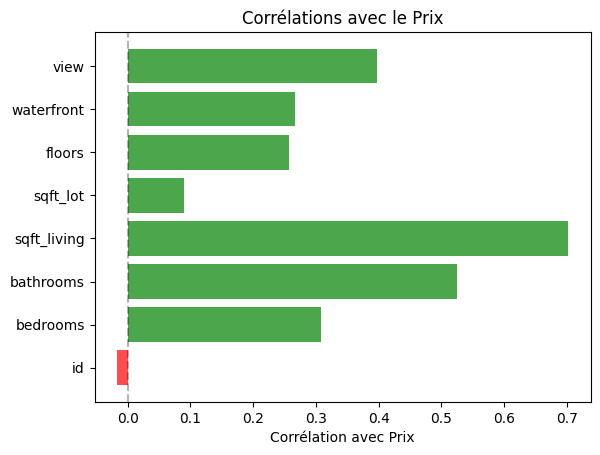

In [21]:
# 3. Corrélations avec le prix (barplot)
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Get numeric columns
numeric_cols = [field.name for field in df.schema.fields
                if field.dataType.typeName() in ['double', 'float', 'integer', 'long']]

# Create feature vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df)

# Calculate correlation matrix
corr_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Convert to pandas for easier plotting
import pandas as pd
corr_df = pd.DataFrame(corr_matrix, columns=numeric_cols, index=numeric_cols)
price_correlations = corr_df['price']
price_corr_plot = price_correlations.drop('price').head(8)

colors = ['red' if x < 0 else 'green' for x in price_corr_plot.values]
plt.barh(range(len(price_corr_plot)), price_corr_plot.values, color=colors, alpha=0.7)
plt.yticks(range(len(price_corr_plot)), price_corr_plot.index)
plt.xlabel('Corrélation avec Prix')
plt.title('Corrélations avec le Prix')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)

Text(0, 0.5, 'Prix')

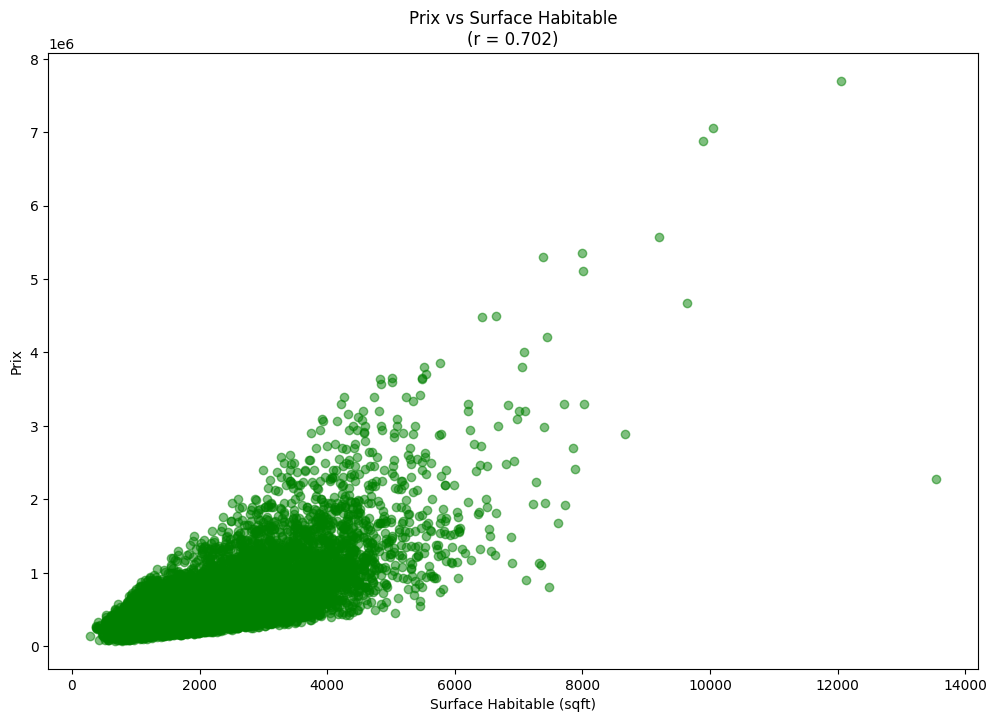

In [84]:
# 4. Prix vs Surface Habitable
# Convert PySpark DataFrame to pandas for plotting
df_pandas = df.toPandas()
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(df_pandas['sqft_living'], df_pandas['price'], alpha=0.5, color='green')
# Calculate correlation directly with pandas
correlation_coeff = df_pandas['price'].corr(df_pandas['sqft_living'])
plt.title(f'Prix vs Surface Habitable\n(r = {correlation_coeff:.3f})')
plt.xlabel('Surface Habitable (sqft)')
plt.ylabel('Prix')

Text(0, 0.5, 'Prix')

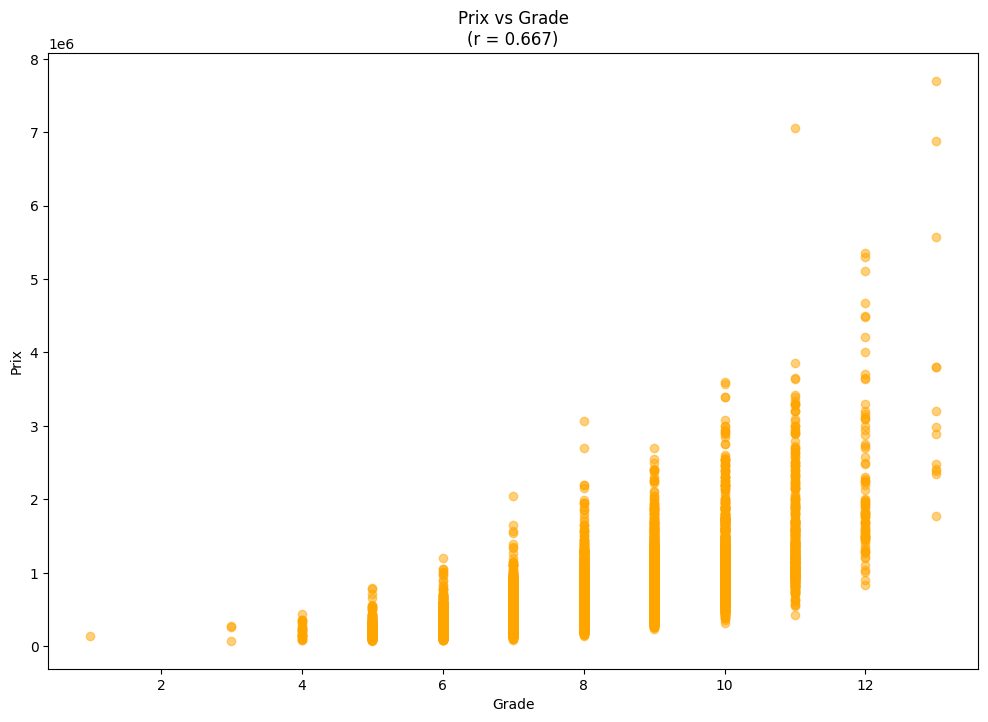

In [85]:
# 5. Prix vs Grade
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(df_pandas['grade'], df_pandas['price'], alpha=0.5, color='orange')
# Calculate correlation directly with pandas
correlation_coeff = df_pandas['price'].corr(df_pandas['grade'])
plt.title(f'Prix vs Grade\n(r = {correlation_coeff:.3f})')
plt.xlabel('Grade')
plt.ylabel('Prix')

Text(0, 0.5, 'Prix')

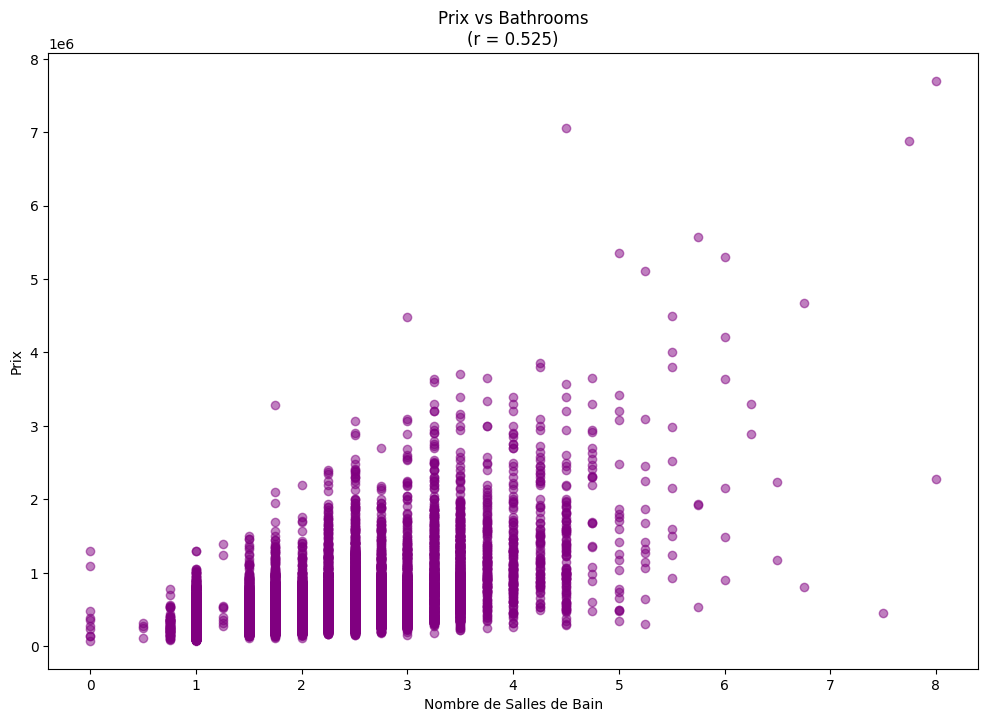

In [86]:
# 6. Prix vs Bathrooms
df_pandas = df.toPandas()
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(df_pandas['bathrooms'], df_pandas['price'], alpha=0.5, color='purple')
# Calculate correlation directly with pandas
correlation_coeff = df_pandas['price'].corr(df_pandas['bathrooms'])
plt.title(f'Prix vs Bathrooms\n(r = {correlation_coeff:.3f})')
plt.xlabel('Nombre de Salles de Bain')
plt.ylabel('Prix')

<ipython-input-87-2302693472>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(bedrooms_data, labels=range(1, 6))


Text(0, 0.5, 'Prix')

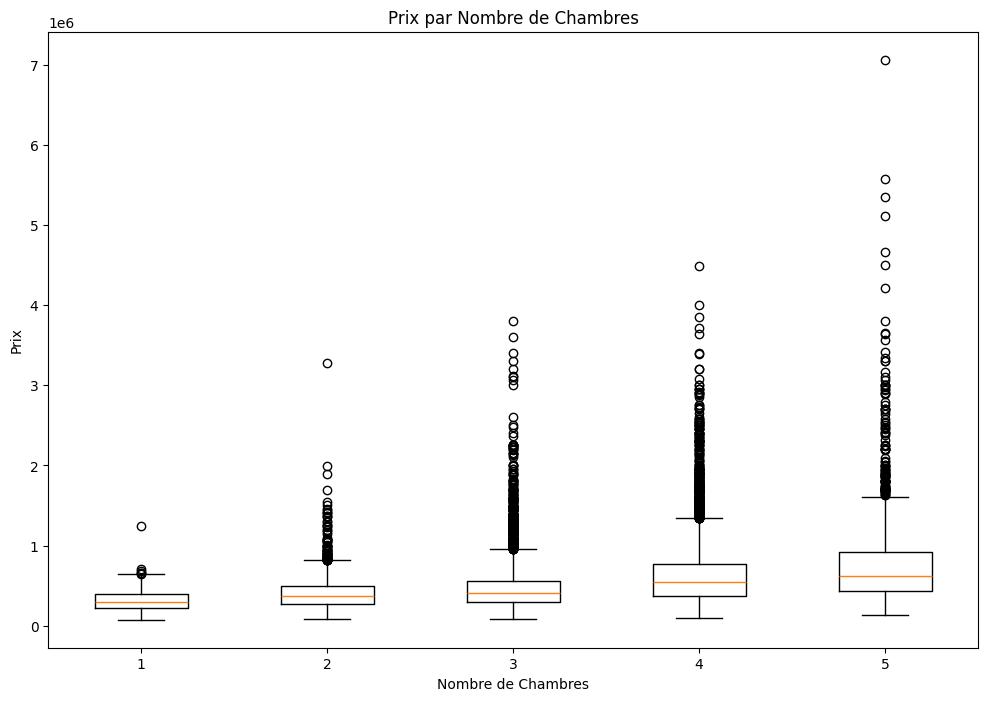

In [87]:
# 7. Prix par nombre de chambres (box plot)
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
bedrooms_data = [df_pandas[df_pandas['bedrooms'] == i]['price'] for i in range(1, 6)]
plt.boxplot(bedrooms_data, labels=range(1, 6))
plt.title('Prix par Nombre de Chambres')
plt.xlabel('Nombre de Chambres')
plt.ylabel('Prix')

Text(0, 0.5, 'Prix')

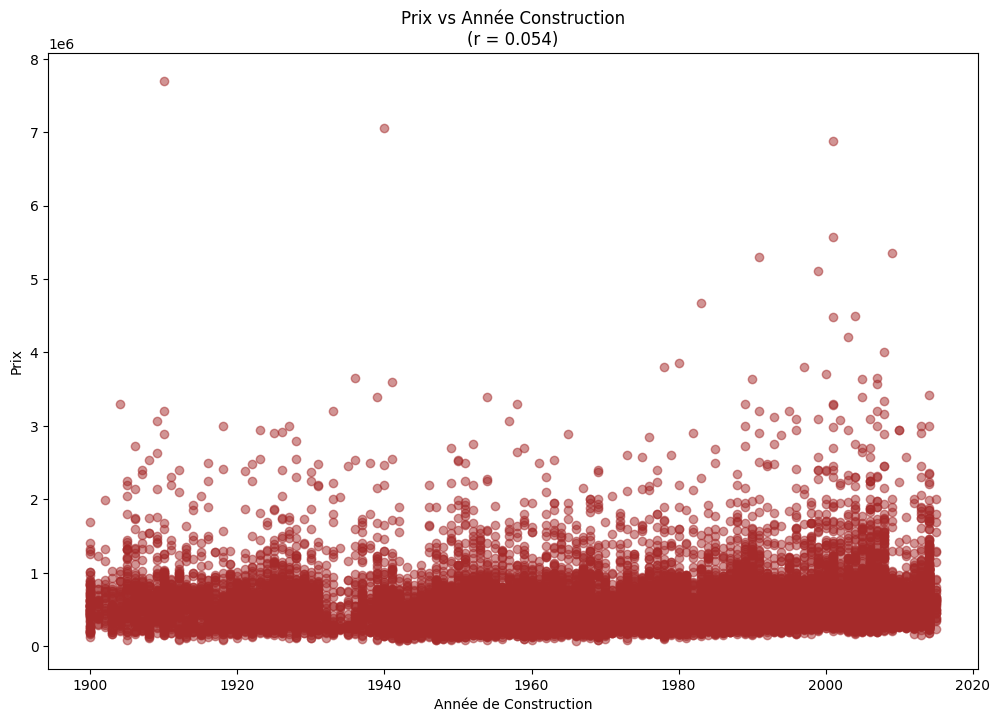

In [88]:
# 8. Prix vs Année de construction
df_pandas = df.toPandas()
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(df_pandas['yr_built'], df_pandas['price'], alpha=0.5, color='brown')
plt.title(f'Prix vs Année Construction\n(r = {df_pandas["price"].corr(df_pandas["yr_built"]):.3f})')
plt.xlabel('Année de Construction')
plt.ylabel('Prix')

Text(0, 0.5, 'Fréquence')

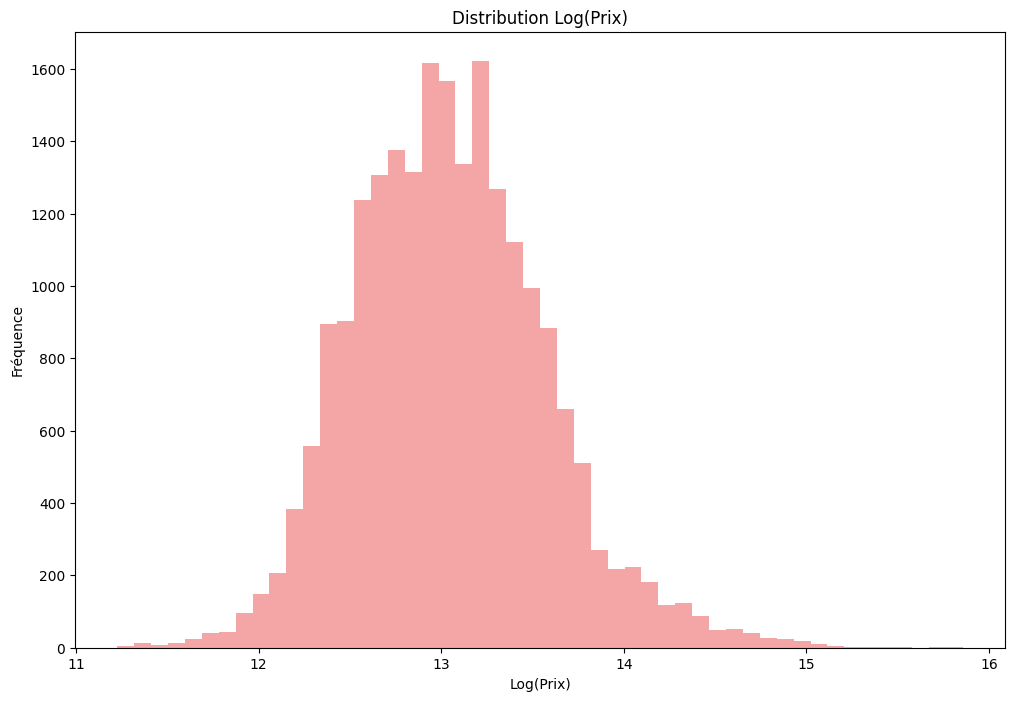

In [89]:
# 9. Distribution log du prix
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.hist(np.log(df_pandas['price']), bins=50, alpha=0.7, color='lightcoral')
plt.title('Distribution Log(Prix)')
plt.xlabel('Log(Prix)')
plt.ylabel('Fréquence')

Text(0, 0.5, 'Latitude')

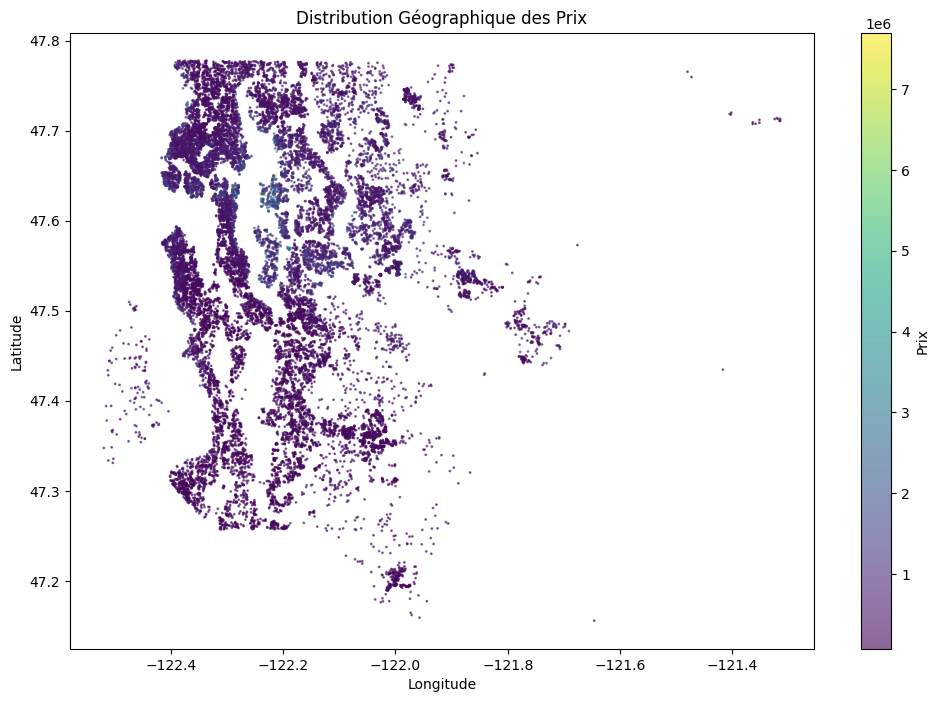

In [90]:
# 10. Variables géographiques
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(df_pandas['long'], df_pandas['lat'], c=df_pandas['price'],
           cmap='viridis', alpha=0.6, s=1)
plt.colorbar(label='Prix')
plt.title('Distribution Géographique des Prix')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0.5, 1.0, 'Corrélation Features Importantes')

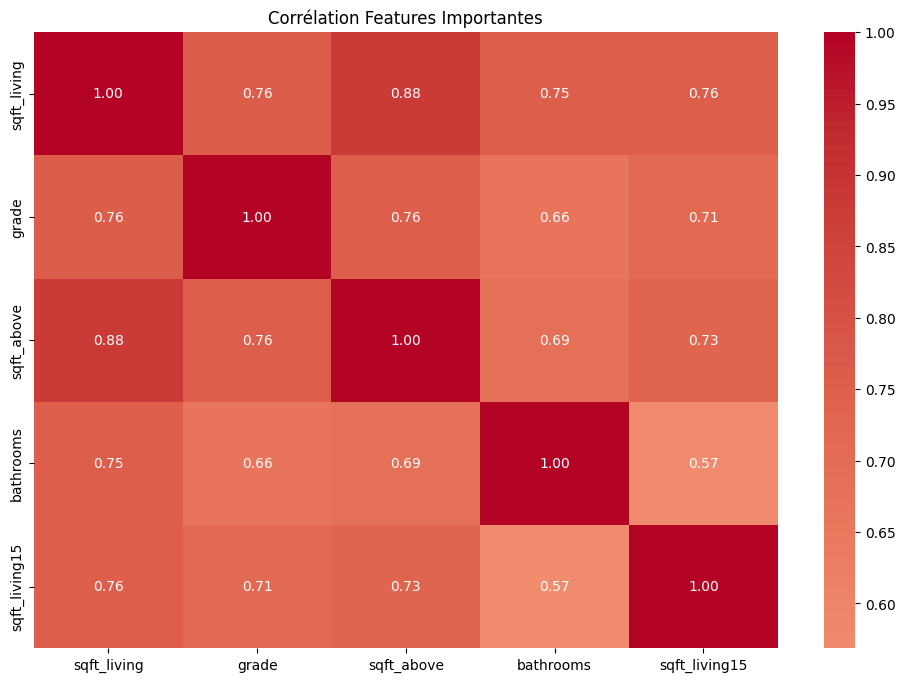

In [91]:
# 11. Corrélation features importantes
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
important_features = ['sqft_living', 'grade', 'sqft_above', 'bathrooms', 'sqft_living15']
important_features = [f for f in important_features if f in df_pandas.columns]

# Create correlation matrix using pandas
corr_matrix_pandas = df_pandas[important_features + ['price']].corr()
corr_important = corr_matrix_pandas.loc[important_features, important_features]

sns.heatmap(corr_important, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corrélation Features Importantes')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

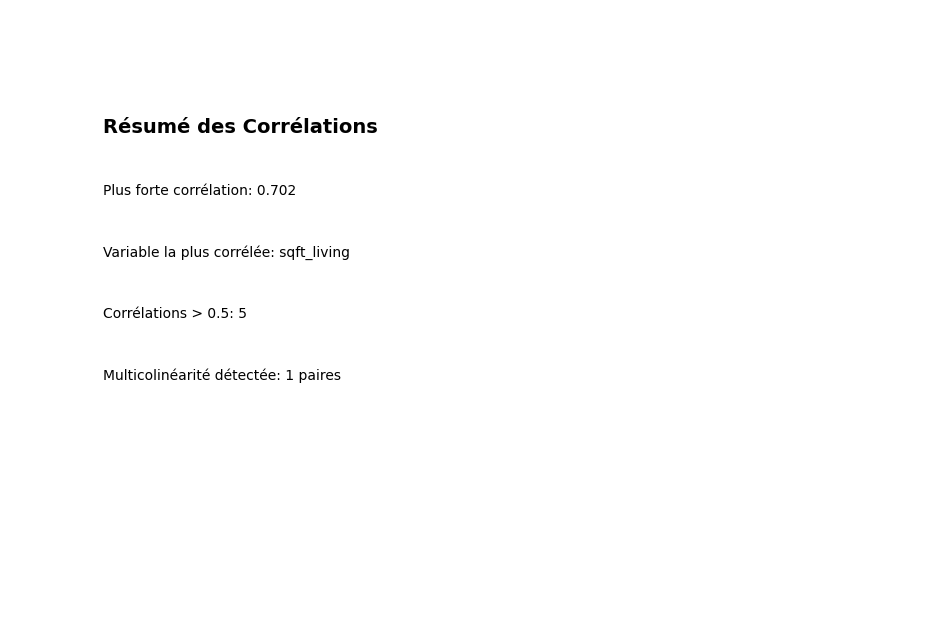

In [92]:
# 12. Résumé textuel
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces

# Convert to pandas and calculate correlations
df_pandas = df.toPandas()
price_correlations = df_pandas.select_dtypes(include=[np.number]).corr()['price']

plt.text(0.1, 0.8, "Résumé des Corrélations", fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f"Plus forte corrélation: {price_correlations.drop('price').abs().max():.3f}", transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f"Variable la plus corrélée: {price_correlations.drop('price').abs().idxmax()}", transform=plt.gca().transAxes)
# Use .sum() instead of sum() for pandas Series
plt.text(0.1, 0.5, f"Corrélations > 0.5: {(price_correlations.drop('price').abs() > 0.5).sum()}", transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f"Multicolinéarité détectée: {len(high_corr_pairs)} paires", transform=plt.gca().transAxes)
plt.axis('off')

#4. PRÉTRAITEMENT DES DONNÉES

In [31]:
# Analyse et suppression intelligente des colonnes
print("🔍 Analyse complète des colonnes:")
print(f"   Total colonnes initiales: {len(df.columns)}")

🔍 Analyse complète des colonnes:
   Total colonnes initiales: 21


In [32]:
# 1. Colonnes évidentes à supprimer (identifiants, dates)
colonnes_evidentes = ['id', 'date']

In [33]:
# 2. Analyse des corrélations pour identifier les colonnes faiblement corrélées
df_temp = df.toPandas()

# Select only numeric columns for correlation analysis
numeric_columns = df_temp.select_dtypes(include=[np.number]).columns
correlation_matrix = df_temp[numeric_columns].corr()

price_correlations = correlation_matrix['price'].abs() if 'price' in correlation_matrix.columns else pd.Series()

In [34]:
# 3. Colonnes avec très faible corrélation (< 0.1)
SEUIL_CORRELATION = 0.1
colonnes_faible_corr = []

if not price_correlations.empty:
    for col, corr in price_correlations.items():
        if col != 'price' and corr < SEUIL_CORRELATION:
            colonnes_faible_corr.append(col)

In [35]:
# 4. Liste complète des colonnes à supprimer
colonnes_a_supprimer = []
# Ajout des colonnes évidentes (si présentes)
for col in colonnes_evidentes:
    if col in df.columns:
        colonnes_a_supprimer.append(col)
# Ajout des colonnes faiblement corrélées (si présentes)
for col in colonnes_faible_corr:
    if col in df.columns:
        colonnes_a_supprimer.append(col)

In [36]:
# Suppression des doublons
colonnes_a_supprimer = list(set(colonnes_a_supprimer))
print(f"\n📊 ANALYSE DES SUPPRESSIONS:")
print(f"   Colonnes évidentes à supprimer: {[col for col in colonnes_evidentes if col in df.columns]}")
print(f"   Colonnes faible corrélation (< {SEUIL_CORRELATION}): {colonnes_faible_corr}")
print(f"   TOTAL à supprimer: {len(colonnes_a_supprimer)} colonnes")


📊 ANALYSE DES SUPPRESSIONS:
   Colonnes évidentes à supprimer: ['id', 'date']
   Colonnes faible corrélation (< 0.1): ['id', 'sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15']
   TOTAL à supprimer: 8 colonnes


In [37]:
# Affichage détaillé des corrélations pour justification
if not price_correlations.empty:
    print(f"\n🔍 Corrélations avec le prix:")
    for col in df.columns:
        if col in price_correlations.index and col != 'price':
            corr_val = price_correlations[col]
            status = "❌ SUPPRIMÉE" if col in colonnes_a_supprimer else "✅ GARDÉE"
            print(f"   {col:15s}: {corr_val:6.3f} - {status}")


🔍 Corrélations avec le prix:
   id             :  0.017 - ❌ SUPPRIMÉE
   bedrooms       :  0.308 - ✅ GARDÉE
   bathrooms      :  0.525 - ✅ GARDÉE
   sqft_living    :  0.702 - ✅ GARDÉE
   sqft_lot       :  0.090 - ❌ SUPPRIMÉE
   floors         :  0.257 - ✅ GARDÉE
   waterfront     :  0.266 - ✅ GARDÉE
   view           :  0.397 - ✅ GARDÉE
   condition      :  0.036 - ❌ SUPPRIMÉE
   grade          :  0.667 - ✅ GARDÉE
   sqft_above     :  0.606 - ✅ GARDÉE
   sqft_basement  :  0.324 - ✅ GARDÉE
   yr_built       :  0.054 - ❌ SUPPRIMÉE
   yr_renovated   :  0.126 - ✅ GARDÉE
   zipcode        :  0.053 - ❌ SUPPRIMÉE
   lat            :  0.307 - ✅ GARDÉE
   long           :  0.022 - ❌ SUPPRIMÉE
   sqft_living15  :  0.585 - ✅ GARDÉE
   sqft_lot15     :  0.082 - ❌ SUPPRIMÉE


In [38]:
# Application de la suppression
if colonnes_a_supprimer:
    df_clean = df.drop(*colonnes_a_supprimer)
    print(f"\n✅ {len(colonnes_a_supprimer)} colonnes supprimées: {colonnes_a_supprimer}")
else:
    df_clean = df
    print(f"\n✅ Aucune colonne à supprimer selon les critères")

print(f"📊 Colonnes restantes: {len(df_clean.columns)} (était {len(df.columns)})")


✅ 8 colonnes supprimées: ['sqft_lot15', 'date', 'sqft_lot', 'zipcode', 'condition', 'long', 'id', 'yr_built']
📊 Colonnes restantes: 13 (était 21)


In [39]:
# Détection et traitement des outliers (méthode IQR)
def detect_outliers(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [40]:
from pyspark.sql.functions import col

# Traitement des outliers pour les colonnes numériques importantes
colonnes_numeriques = ['price', 'grade', 'sqft_living15', 'sqft_living', 'bathrooms', 'view', 'bedrooms', 'lat', 'waterfront', 'floors', 'yr_renovated', 'sqft_above', 'sqft_basement']

for column_name in colonnes_numeriques:
    if column_name in df_clean.columns:
        lower, upper = detect_outliers(df_clean, column_name)
        count_before = df_clean.count()
        df_clean = df_clean.filter((col(column_name) >= lower) & (col(column_name) <= upper))
        count_after = df_clean.count()
        print(f"📊 {column_name}: {count_before - count_after} outliers supprimés")

📊 price: 1182 outliers supprimés
📊 grade: 1174 outliers supprimés
📊 sqft_living15: 257 outliers supprimés
📊 sqft_living: 189 outliers supprimés
📊 bathrooms: 34 outliers supprimés
📊 view: 1317 outliers supprimés
📊 bedrooms: 323 outliers supprimés
📊 lat: 0 outliers supprimés
📊 waterfront: 0 outliers supprimés
📊 floors: 0 outliers supprimés
📊 yr_renovated: 589 outliers supprimés
📊 sqft_above: 393 outliers supprimés
📊 sqft_basement: 495 outliers supprimés


In [41]:
# Feature Engineering
print("\n🔨 FEATURE ENGINEERING")
df_clean = df_clean.withColumn("price_per_sqft", col("price") / col("sqft_living"))
df_clean = df_clean.withColumn("total_rooms", col("bedrooms") + col("bathrooms"))
df_clean = df_clean.withColumn("years_since_renovation",
                               when(col("yr_renovated") > 0, 2024 - col("yr_renovated"))
                               .otherwise(0))  # Use 0 instead of None
df_clean = df_clean.withColumn("renovated", when(col("yr_renovated") > 0, 1).otherwise(0))



🔨 FEATURE ENGINEERING


In [42]:
# Transformation logarithmique du prix pour normaliser
df_clean = df_clean.withColumn("log_price", log(col("price")))
# Remove the duplicate age column
df_clean = df_clean.drop("age_since_renovation")

print("✅ Nouvelles variables créées: price_per_sqft, total_rooms, years_since_renovation, renovated, log_price")

✅ Nouvelles variables créées: price_per_sqft, total_rooms, years_since_renovation, renovated, log_price


In [43]:
# Sélection finale des features pour le machine learning
# (basée sur les colonnes restantes après suppression)
feature_cols = [col for col in df_clean.columns
                if col not in ['price', 'log_price']]

print(f"\n🎯 FEATURES POUR LE MACHINE LEARNING:")
print(f"   Variables disponibles: {len(feature_cols)}")
print(f"   Liste: {feature_cols}")




🎯 FEATURES POUR LE MACHINE LEARNING:
   Variables disponibles: 16
   Liste: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15', 'price_per_sqft', 'total_rooms', 'years_since_renovation', 'renovated']


In [44]:
# Vérification de la qualité des features
if len(feature_cols) < 5:
    print("⚠️  ATTENTION: Peu de variables disponibles, considérez ajuster le seuil de corrélation")
elif len(feature_cols) > 20:
    print("⚠️  ATTENTION: Beaucoup de variables, le modèle pourrait être complexe")

#5. PRÉPARATION POUR LE MACHINE LEARNING

In [45]:
# Assemblage des features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


In [46]:
# Normalisation des features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features"
)

In [47]:
# Check for null/NaN values in individual feature columns
feature_cols = [col for col in df_clean.columns if col not in ['price', 'log_price']]

for col_name in feature_cols:
    null_count = df_clean.select(count(when(col(col_name).isNull() | isnan(col(col_name)), col_name))).collect()[0][0]
    print(f"{col_name}: {null_count} null/NaN values")

bedrooms: 0 null/NaN values
bathrooms: 0 null/NaN values
sqft_living: 0 null/NaN values
floors: 0 null/NaN values
waterfront: 0 null/NaN values
view: 0 null/NaN values
grade: 0 null/NaN values
sqft_above: 0 null/NaN values
sqft_basement: 0 null/NaN values
yr_renovated: 0 null/NaN values
lat: 0 null/NaN values
sqft_living15: 0 null/NaN values
price_per_sqft: 0 null/NaN values
total_rooms: 0 null/NaN values
years_since_renovation: 0 null/NaN values
renovated: 0 null/NaN values


In [48]:
# Application des transformations
df_clean.select(count(when(col("years_since_renovation").isNull(), "years_since_renovation"))).show()
df_assembled = assembler.transform(df_clean)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

+---------------------------------------------------------------------------------+
|count(CASE WHEN (years_since_renovation IS NULL) THEN years_since_renovation END)|
+---------------------------------------------------------------------------------+
|                                                                                0|
+---------------------------------------------------------------------------------+



In [49]:
# Division train/test (80/20)
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

print(f"📊 Données d'entraînement: {train_df.count()} échantillons")
print(f"📊 Données de test: {test_df.count()} échantillons")

📊 Données d'entraînement: 12590 échantillons
📊 Données de test: 3070 échantillons


#5. MODÉLISATION RANDOM FOREST

In [50]:
# Configuration du modèle Random Forest
rf = RandomForestRegressor(
    featuresCol="scaled_features",
    labelCol="price",
    seed=42
)

In [51]:
# Définition de la grille de paramètres pour l'optimisation
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100,]) \
    .addGrid(rf.maxDepth, [10, 15,]) \
    .addGrid(rf.minInstancesPerNode, [1, 5,]) \
    .build()

In [52]:
# Configuration de l'évaluateur
evaluator = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction",
    metricName="rmse"
)

In [53]:
# Validation croisée pour l'optimisation des hyperparamètres
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)
print("⚙️  Démarrage de l'optimisation des hyperparamètres (3-fold CV)...")

⚙️  Démarrage de l'optimisation des hyperparamètres (3-fold CV)...


In [54]:
# Entraînement avec optimisation
cv_model = crossval.fit(train_df)
best_model = cv_model.bestModel

print("✅ Optimisation terminée!")
print(f"🎯 Meilleurs paramètres:")
print(f"   - Nombre d'arbres: {best_model.getNumTrees}")
print(f"   - Profondeur max: {best_model.getMaxDepth()}")
print(f"   - Min instances par nœud: {best_model.getMinInstancesPerNode()}")

✅ Optimisation terminée!
🎯 Meilleurs paramètres:
   - Nombre d'arbres: 100
   - Profondeur max: 15
   - Min instances par nœud: 1


#6. ÉVALUATION DU MODÈLE

In [55]:
# Prédictions sur les données de test
predictions = best_model.transform(test_df)

In [56]:
# Calcul des métriques
rmse_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")

rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"📈 MÉTRIQUES DE PERFORMANCE:")
print(f"   🎯 RMSE: ${rmse:,.2f}")
print(f"   🎯 R²: {r2:.4f}")
print(f"   🎯 MAE: ${mae:,.2f}")

📈 MÉTRIQUES DE PERFORMANCE:
   🎯 RMSE: $22,360.12
   🎯 R²: 0.9830
   🎯 MAE: $12,546.64


In [57]:
# Calcul de la précision en pourcentage
mean_price = df_clean.select(avg("price")).collect()[0][0]
accuracy_percentage = (1 - (rmse / mean_price)) * 100
print(f"   🎯 Précision: {accuracy_percentage:.2f}%")

   🎯 Précision: 94.82%


#7. ANALYSE DE L'IMPORTANCE DES VARIABLES

In [68]:
# Extraction de l'importance des features
feature_importance = best_model.featureImportances.toArray()
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("📊 Top 10 des variables les plus importantes:")
print(importance_df.head(10).to_string(index=False))

📊 Top 10 des variables les plus importantes:
       feature  importance
price_per_sqft    0.342117
           lat    0.234823
   sqft_living    0.194178
         grade    0.076028
    sqft_above    0.064822
 sqft_living15    0.034842
 sqft_basement    0.017171
   total_rooms    0.015831
     bathrooms    0.011644
      bedrooms    0.004691


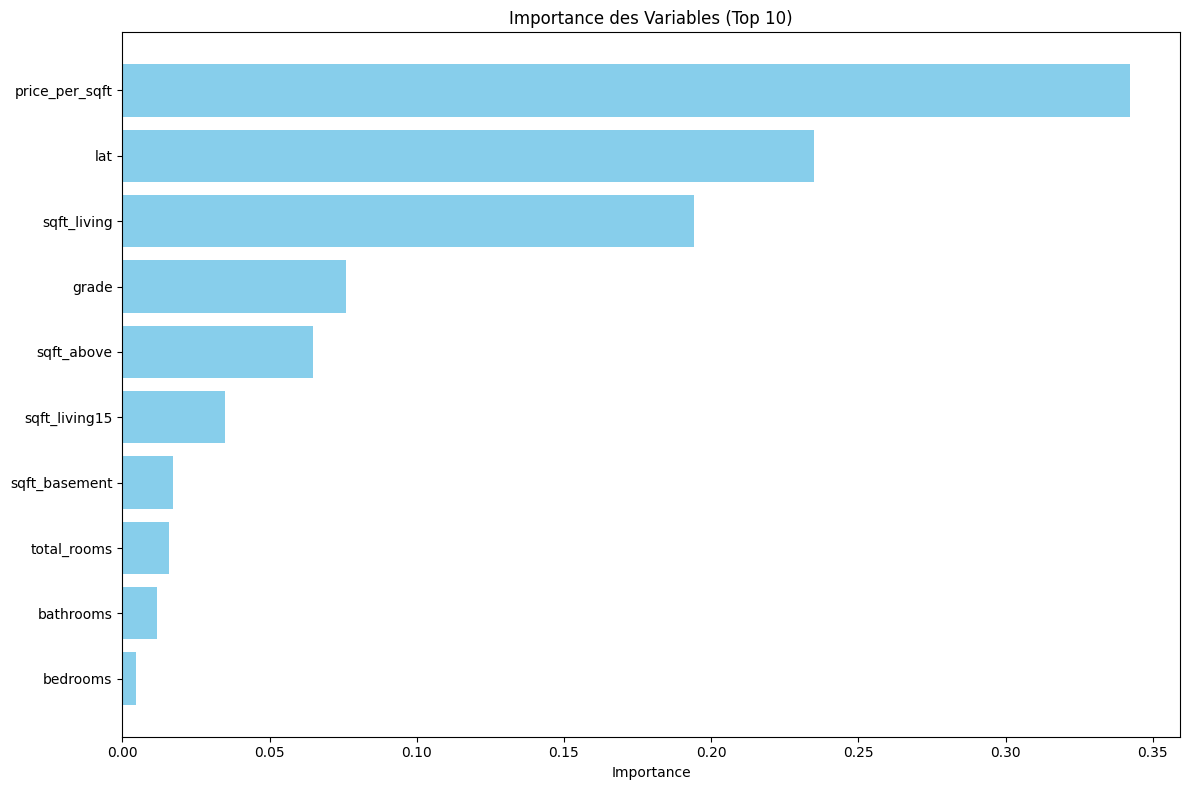

In [70]:
# Visualisation de l'importance des variables
plt.figure(figsize=(12, 8))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Importance des Variables (Top 10)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#8. VISUALISATION DES RÉSULTATS

In [71]:
# Conversion des prédictions en pandas pour visualisation
pred_pandas = predictions.select("price", "prediction").toPandas()

plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0.5, 1.0, 'Prédictions vs Valeurs Réelles')

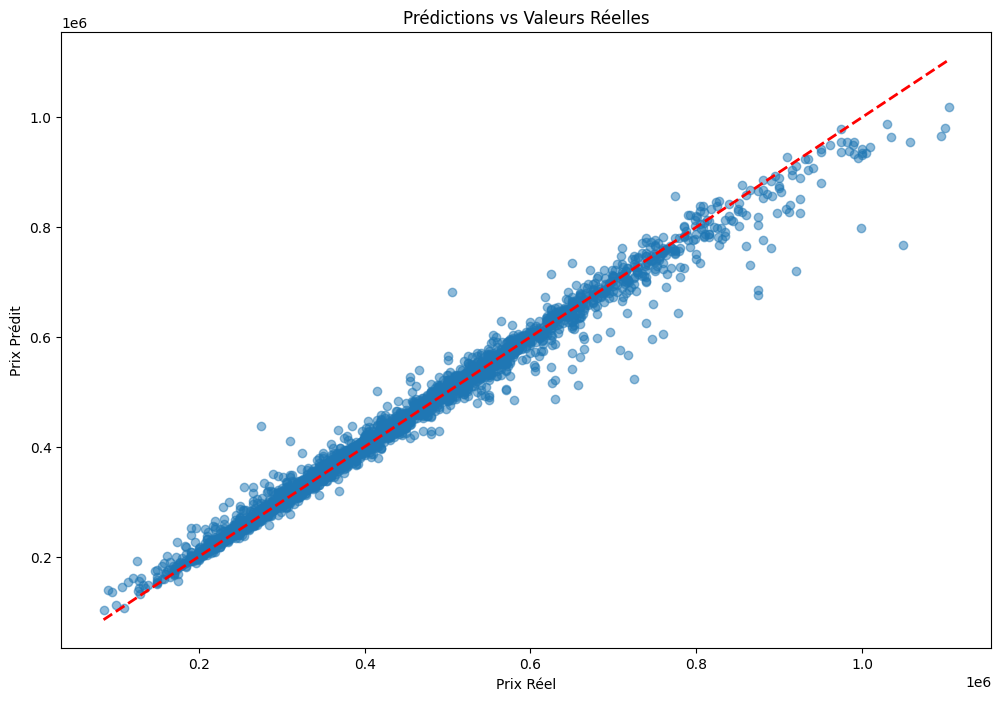

In [93]:
# Graphique des prédictions vs valeurs réelles
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
plt.scatter(pred_pandas['price'], pred_pandas['prediction'], alpha=0.5)
plt.plot([pred_pandas['price'].min(), pred_pandas['price'].max()],
         [pred_pandas['price'].min(), pred_pandas['price'].max()], 'r--', lw=2)
plt.xlabel('Prix Réel')
plt.ylabel('Prix Prédit')
plt.title('Prédictions vs Valeurs Réelles')

Text(0.5, 1.0, 'Distribution des Résidus')

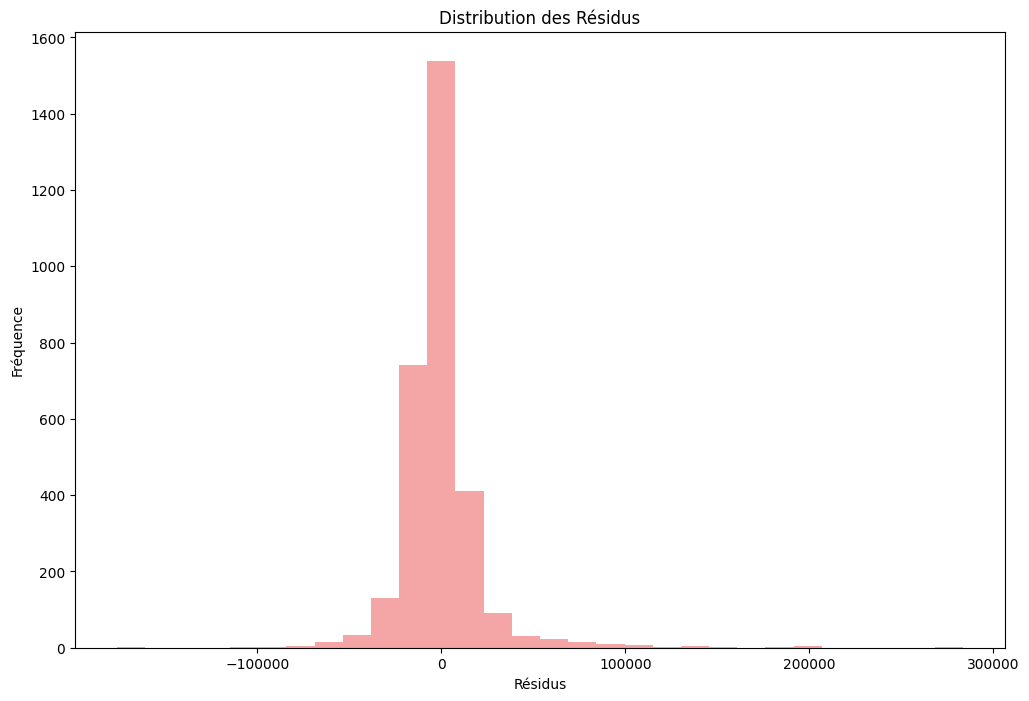

In [94]:
# Distribution des résidus
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
residuals = pred_pandas['price'] - pred_pandas['prediction']
plt.hist(residuals, bins=30, alpha=0.7, color='lightcoral')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des Résidus')

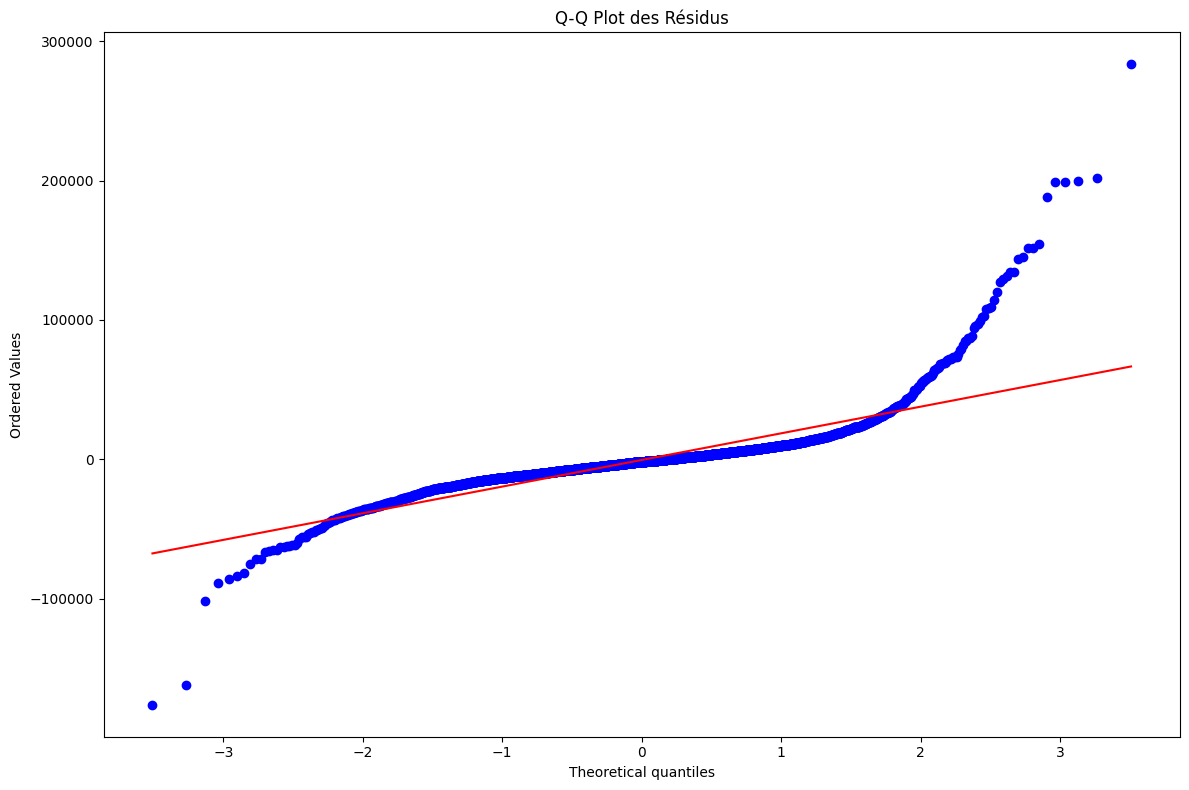

In [95]:
# Q-Q plot des résidus
# Définir la taille par défaut pour tous les graphiques
plt.rcParams['figure.figsize'] = (12, 8)  # largeur, hauteur en pouces
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot des Résidus')
plt.tight_layout()
plt.show()

#9. CONCLUSION ET RECOMMANDATIONS

In [97]:
print(f"""
📊 RÉSUMÉ DE LA PERFORMANCE:
   • Le modèle Random Forest atteint un R² de {r2:.4f}, expliquant {r2*100:.2f}% de la variance
   • RMSE de ${rmse:,.0f}, soit une erreur moyenne de {(rmse/mean_price)*100:.1f}%
   • Les variables les plus importantes sont: {', '.join(importance_df.head(3)['feature'].tolist())}
🔧 OPTIMISATIONS RÉALISÉES:
   • Suppression des outliers avec la méthode IQR
   • Feature engineering avec création de variables dérivées
   • Optimisation des hyperparamètres par validation croisée
   • Normalisation des features avec StandardScaler


""")



📊 RÉSUMÉ DE LA PERFORMANCE:
   • Le modèle Random Forest atteint un R² de 0.9830, expliquant 98.30% de la variance
   • RMSE de $22,360, soit une erreur moyenne de 5.2%
   • Les variables les plus importantes sont: price_per_sqft, lat, sqft_living
🔧 OPTIMISATIONS RÉALISÉES:
   • Suppression des outliers avec la méthode IQR
   • Feature engineering avec création de variables dérivées
   • Optimisation des hyperparamètres par validation croisée
   • Normalisation des features avec StandardScaler





In [76]:
# Sauvegarde du modèle (optionnel)
# best_model.write().overwrite().save("modele_rf_immobilier")
print("✅ Analyse terminée avec succès!")

✅ Analyse terminée avec succès!
